In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
import os
import matplotlib.pyplot as plt
from torch_geometric.data import Data

In [ ]:
# Hyperparameters
HIDDEN_CHANNELS = 64
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
# Load the data
def load_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset


In [ ]:
# Theoretical saturation throughput calculation
def theoretical_saturation_throughput(transmission_prob, T, sigma, G):
    num_nodes = len(transmission_prob)
    S = np.zeros(num_nodes)

    for i in range(num_nodes):
        p_i = transmission_prob[i]
        prod_other = np.prod([1 - transmission_prob[j] for j in range(num_nodes) if G[i][j] == 1 and j != i])
        numerator = p_i * prod_other * T
        denominator = sigma * prod_other * (1 - p_i) + (p_i * prod_other) * T + (1 - ((prod_other * (1 - p_i)) + p_i * prod_other)) * T

        S[i] = numerator / denominator

    return S

In [166]:
class EnhancedGNN(torch.nn.Module):
    def __init__(self, hidden_channels, input_dim, num_nodes):
        super(EnhancedGNN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GATConv(input_dim, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels, heads=1, concat=True)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, num_nodes)  # Changed to output number of nodes

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        return x


In [ ]:
def process_dataset(dataset, G, T, sigma):
    theoretical_errors = []
    theoretical_st_list = []
    G_flattened = G.flatten()
    
    new_dataset = []
    
    for data in dataset:
        num_nodes = data.x.size(0)
        transmission_prob = data.x[:, 0].numpy()  # Extract only the transmission probabilities
        actual_st = data.y.numpy()
        theoretical_st = theoretical_saturation_throughput(transmission_prob, T, sigma, G)
        theoretical_st_list.append(theoretical_st)
        error = np.abs(actual_st - theoretical_st).mean()  # Use mean error
        theoretical_errors.append(error)
        
        # Normalize transmission probabilities
        normalized_features = transmission_prob
        
        # Append G, T, and sigma to the feature matrix
        new_features = np.hstack([normalized_features, G_flattened, [T], [sigma]])
        new_features = new_features.reshape(1, -1)
        
        new_x = torch.tensor(new_features, dtype=torch.float)
        
        # Update edge_index for the new single node format
        edge_index = torch.tensor([[0, 0, 0, 0], [0, 0, 0, 0]], dtype=torch.long)
        
        new_data = Data(x=new_x, edge_index=edge_index, y=data.y)
        new_dataset.append(new_data)
    
    return new_dataset, theoretical_errors, theoretical_st_list

# Verify the output
filename = 'data/data_1000_samples_4_nodes.pkl'
T = 3
sigma = 1
G = np.array([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0]
])

# Load dataset
dataset = load_data(filename)

# Process dataset to calculate theoretical error, normalize features, and append parameters
dataset, theoretical_errors, theoretical_st_list = process_dataset(dataset, G, T, sigma)
print(f"Average Theoretical Error: {np.mean(theoretical_errors):.4f}")


Average Theoretical Error: 0.0126


In [169]:
# Split the data into train, validation, and test sets
def split_data(dataset, test_size=0.2, val_size=0.1):
    train_val_data, test_data = train_test_split(dataset, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_val_data, test_size=val_size / (1 - test_size), random_state=42)
    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = split_data(dataset)
print(f"Train Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")

print("Train Data:")
print(train_data[0].x)
print("Validation Data:")
print(val_data[0].x)
print("Test Data:")
print(test_data[0].x)

# Create DataLoader with the new dataset
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)



Train Data: 700 samples
Validation Data: 100 samples
Test Data: 200 samples
Train Data:
tensor([[0.6451, 0.9455, 0.0911, 0.5591, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 5.0000, 1.0000]])
Validation Data:
tensor([[0.6208, 0.6053, 0.2399, 0.9427, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 5.0000, 1.0000]])
Test Data:
tensor([[0.9683, 0.2549, 0.1690, 0.2778, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 5.0000, 1.0000]])


In [170]:
# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
        target = data.y.view(out.size(0), -1)  # Ensure target shape matches prediction shape
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_error = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
            target = data.y.view(out.size(0), -1)  # Ensure target shape matches prediction shape
            loss = criterion(out, target)
            total_loss += loss.item()
            total_error += torch.abs(out - target).sum().item()
    return total_loss / len(loader), total_error / len(loader.dataset)

# Initialize model, optimizer, and loss function
input_dim = train_data[0].x.size(1)  # Updated input dimension based on new features
model = EnhancedGNN(hidden_channels=HIDDEN_CHANNELS, input_dim=input_dim, num_nodes=4)  # Ensure num_nodes is passed
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()

In [171]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_error = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Error: {val_error:.4f}')

Epoch 001, Train Loss: 0.0692, Val Loss: 0.0199, Val Error: 0.3993
Epoch 002, Train Loss: 0.0165, Val Loss: 0.0076, Val Error: 0.2505
Epoch 003, Train Loss: 0.0086, Val Loss: 0.0052, Val Error: 0.2156
Epoch 004, Train Loss: 0.0065, Val Loss: 0.0052, Val Error: 0.2050
Epoch 005, Train Loss: 0.0055, Val Loss: 0.0055, Val Error: 0.2158
Epoch 006, Train Loss: 0.0051, Val Loss: 0.0050, Val Error: 0.2009
Epoch 007, Train Loss: 0.0052, Val Loss: 0.0042, Val Error: 0.1865
Epoch 008, Train Loss: 0.0039, Val Loss: 0.0028, Val Error: 0.1464
Epoch 009, Train Loss: 0.0031, Val Loss: 0.0034, Val Error: 0.1675
Epoch 010, Train Loss: 0.0025, Val Loss: 0.0026, Val Error: 0.1512
Epoch 011, Train Loss: 0.0023, Val Loss: 0.0015, Val Error: 0.1245
Epoch 012, Train Loss: 0.0019, Val Loss: 0.0021, Val Error: 0.1323
Epoch 013, Train Loss: 0.0026, Val Loss: 0.0030, Val Error: 0.1610
Epoch 014, Train Loss: 0.0027, Val Loss: 0.0024, Val Error: 0.1477
Epoch 015, Train Loss: 0.0021, Val Loss: 0.0022, Val Error: 0.

In [138]:
# Additional evaluation metrics
def additional_metrics(model, loader):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
            target = data.y.view(out.size(0), -1)
            all_targets.append(target.numpy())
            all_predictions.append(out.numpy())
    
    all_targets = np.vstack(all_targets).flatten()  # Flatten to 1D
    all_predictions = np.vstack(all_predictions).flatten()  # Flatten to 1D
    
    mae = mean_absolute_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    
    return mae, r2

# Test the model
test_loss, test_error = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Error: {test_error:.4f}')

# Calculate additional evaluation metrics
mae, r2 = additional_metrics(model, test_loader)
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared: {r2:.4f}')


Test Loss: 0.0009, Test Error: 0.0233
Mean Absolute Error (MAE): 0.0233
R-squared: 0.8284


In [174]:
# Calculate theoretical ST values for the test data
theoretical_st_list_test = []
for data in test_data:
    transmission_prob = data.x[0, :num_nodes].numpy()  # Extract only the transmission probabilities
    theoretical_st = theoretical_saturation_throughput(transmission_prob, T, sigma, G)
    theoretical_st_list_test.append(theoretical_st)  # Store the theoretical ST values

# Calculate predicted ST values for the test data
predicted_st_list = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x.view(-1, data.x.size(-1)), data.edge_index, data.batch)
        if out.shape[1] == num_nodes:  # Ensure the output shape matches the number of nodes
            predicted_st_list.append(out.numpy())  # Store the values directly as list of arrays
        else:
            print(f"Skipped due to shape mismatch: {out.shape}")

# Extract actual ST values from the test data
actual_st = [data.y.numpy().flatten() for data in test_data if data.y.shape[0] == num_nodes]

# Debug: Print the lists before converting to numpy arrays
print("theoretical_st_list_test:", len(theoretical_st_list_test))
print("predicted_st_list:", len(predicted_st_list))
print("actual_st:", len(actual_st))

# Check if lists are empty before converting to numpy arrays
if not theoretical_st_list_test or not predicted_st_list or not actual_st:
    print("One of the lists is empty. Please check the data.")
else:
    # Convert lists to numpy arrays
    theoretical_st_list_test = np.vstack(theoretical_st_list_test)
    predicted_st_list = np.vstack([np.resize(arr, (num_nodes, num_nodes)) for arr in predicted_st_list])
    actual_st = np.vstack(actual_st)

    # Debug: Print lengths and sample values
    print("Length of actual_st:", len(actual_st))
    print("Length of theoretical_st_list_test:", len(theoretical_st_list_test))
    print("Length of predicted_st_list:", len(predicted_st_list))

    print("actual_st:", actual_st[0:5])
    print("theoretical_st_list_test:", theoretical_st_list_test[0:5])
    print("predicted_st_list:", predicted_st_list[0:5])


theoretical_st_list_test: 200
predicted_st_list: 7
actual_st: 200
Length of actual_st: 200
Length of theoretical_st_list_test: 200
Length of predicted_st_list: 28
actual_st: [[0.5285 0.009  0.1055 0.009 ]
 [0.086  0.4245 0.0485 0.17  ]
 [0.0935 0.0015 0.528  0.017 ]
 [0.0065 0.005  0.009  0.005 ]
 [0.008  0.065  0.027  0.089 ]]
theoretical_st_list_test: [[0.52825874 0.0068168  0.14160532 0.00742738]
 [0.09364585 0.47130086 0.05426115 0.22197826]
 [0.14605793 0.00183034 0.52129485 0.01428221]
 [0.00498899 0.00187748 0.00828832 0.00203977]
 [0.00675125 0.06555121 0.02344374 0.0906236 ]]
predicted_st_list: [[0.5558942  0.00470696 0.19436447 0.01918564]
 [0.11396664 0.36960858 0.03941873 0.13710824]
 [0.19732413 0.00494135 0.5017088  0.04430375]
 [0.00639219 0.01019675 0.0121245  0.02667969]
 [0.01643179 0.01671807 0.03411536 0.03898399]]


Adjusted length of actual_st: 28
Adjusted length of theoretical_st: 28
Adjusted length of predicted_st: 28


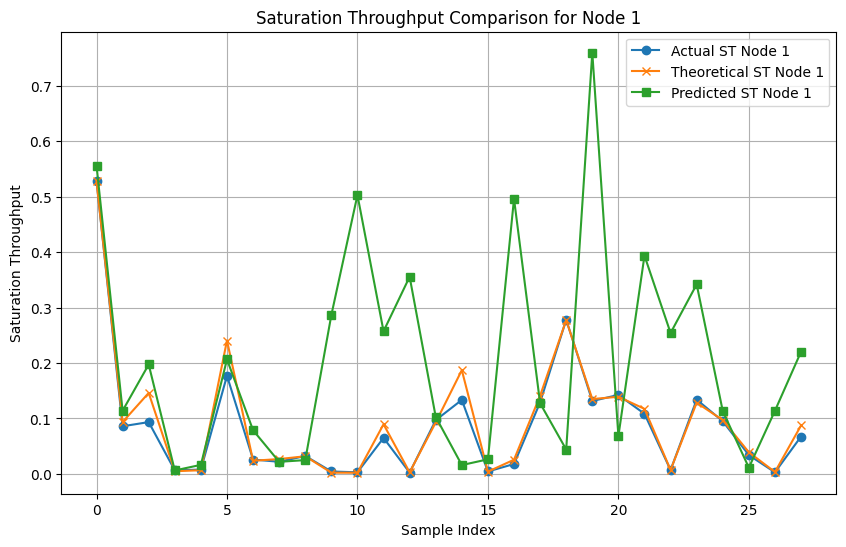

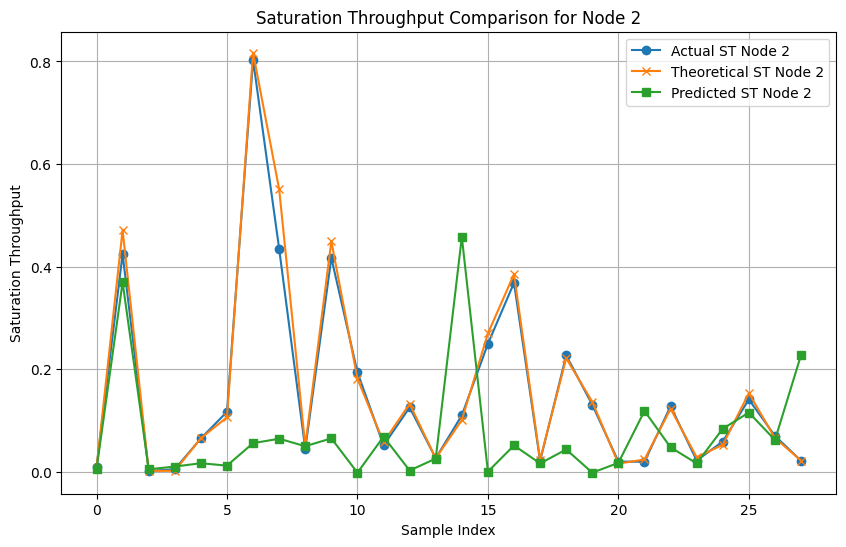

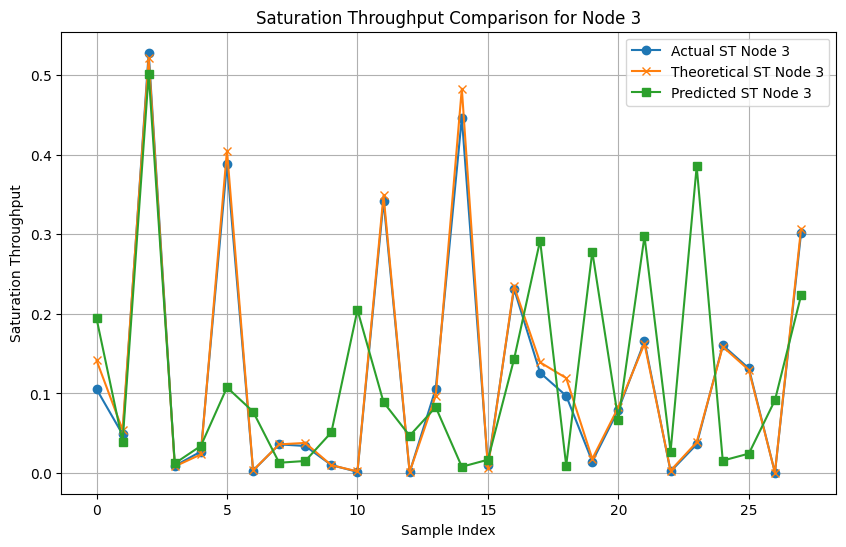

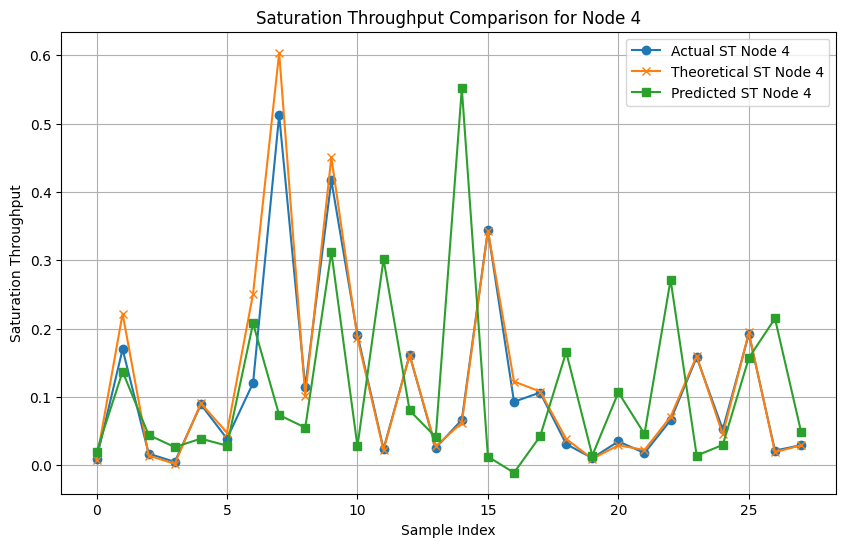

In [175]:
# Plotting function
def plot_results(num_nodes, actual_st, theoretical_st, predicted_st):
    for i in range(num_nodes):
        plt.figure(figsize=(10, 6))
        plt.plot(actual_st[:, i], label=f'Actual ST Node {i+1}', marker='o')
        plt.plot(theoretical_st[:, i], label=f'Theoretical ST Node {i+1}', marker='x')
        plt.plot(predicted_st[:, i], label=f'Predicted ST Node {i+1}', marker='s')
        plt.xlabel('Sample Index')
        plt.ylabel('Saturation Throughput')
        plt.title(f'Saturation Throughput Comparison for Node {i+1}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Ensure all arrays have the same length
min_length = min(len(actual_st), len(theoretical_st_list_test), len(predicted_st_list))
actual_st = actual_st[:min_length]
theoretical_st = theoretical_st_list_test[:min_length]
predicted_st = predicted_st_list[:min_length]

# Debug: Print adjusted lengths
print("Adjusted length of actual_st:", len(actual_st))
print("Adjusted length of theoretical_st:", len(theoretical_st))
print("Adjusted length of predicted_st:", len(predicted_st))

# Plot results
plot_results(num_nodes, actual_st, theoretical_st, predicted_st)
